In [1]:
import sys
sys.path.append("../")
import numpy as np
import os
import glob
import cv2
import csv
from scipy.signal import find_peaks
from utils import AnteriorPosterior, AnteriorPosteriorTime, tripleplot
import pandas as pd
from tifffile import imread, imwrite
import matplotlib.pyplot as plt
try:
    from pathlib import Path
    Path().expanduser()
except (ImportError, AttributeError):
        from pathlib2 import Path

try:
        import tempfile
        tempfile.TemporaryDirectory
except (ImportError, AttributeError):
       from backports import tempfile

In [2]:
Kymo = '/home/kapoorlab/Downloads/Darine/Dpachys_10/DistanceMethodCurvature_Dpachys_controlTrackID1.tif'
Embryo = '/home/kapoorlab/Downloads/Darine/Dpachys_10/Dpachys_control.tif'
Csv = '/home/kapoorlab/Downloads/Darine/Dpachys_10/Co-ordinatesETrack_Dpachys_controlCellID01.txt'
savedir = '/home/kapoorlab/Downloads/Darine/Dpachys_10/Results/'
Path(savedir).mkdir(exist_ok = True)

In [3]:
#Calibration units for time qnd space
Time_unit = 10
Xcalibration = 0.034


#Parameters
#Remove zero end of kymograph
cutEnd = 300
#This is what makes a peak a peak, the height of peaks around this main peak height threshold
Heightthreshold = 0.005

#More parameters
#Just for display, not important parameters
displayskip = 2
blocksize = 50


In [4]:
Kymoimage = imread(Kymo)
Embryoimage = imread(Embryo)
Kymoimage = Kymoimage[:Kymoimage.shape[0]-cutEnd,:]

AnteriorStart = 0
AnteriorEnd = Kymoimage.shape[0]//2
PosteriorStart = AnteriorEnd
PosteriorEnd = Kymoimage.shape[0] 
x, y, t, distance, perimeter, N, M = np.loadtxt(Csv, skiprows = 3, unpack=True)
Blockiter = int(len(x)/max(t))
print('Total Perimeter points on Kymo:', Blockiter)
Dictionary = []
for i in range(0, Blockiter):
    Dictionary.append([i, x[i], y[i]])


Total Perimeter points on Kymo: 2401


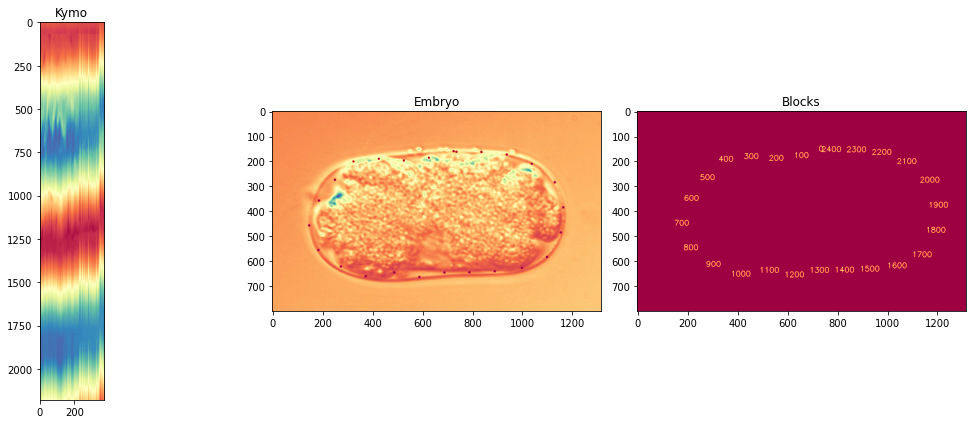

In [5]:
# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
# org 
org = (50, 50) 
# fontScale 
fontScale = 1
 
color = (255, 255, 0) 
thickness = 1
Clock = np.zeros([Embryoimage.shape[1], Embryoimage.shape[2]])
for i in range(0, Blockiter, 2 *blocksize):
    cv2.circle(Embryoimage[0,:], (int(x[i]), int(y[i])), 5,(255,0,0), thickness = -1 )
    cv2.putText(Clock, str(i), (int(x[i]), int(y[i])), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
tripleplot(Kymoimage,Embryoimage[0,:], Clock, 'Kymo', 'Embryo', 'Blocks')

Estimated Anterior Velocity 0.00750527027027027 um/min
Estimated Posterior Velocity 0 um/min


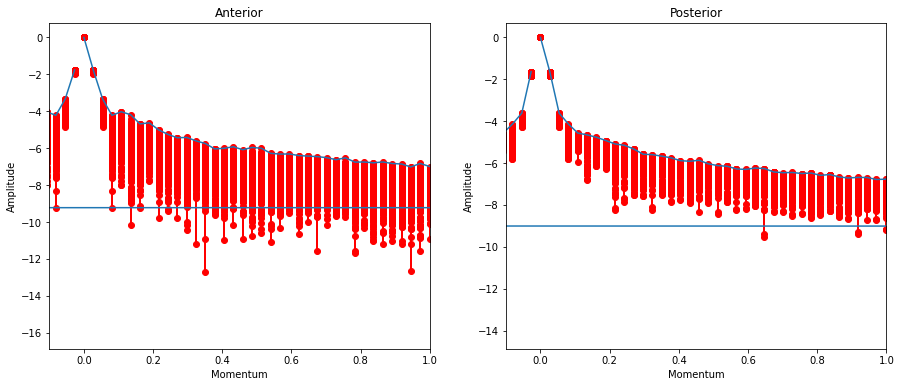

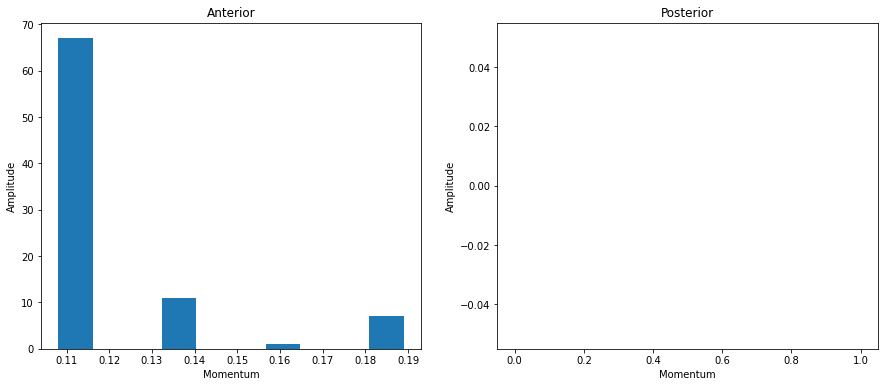

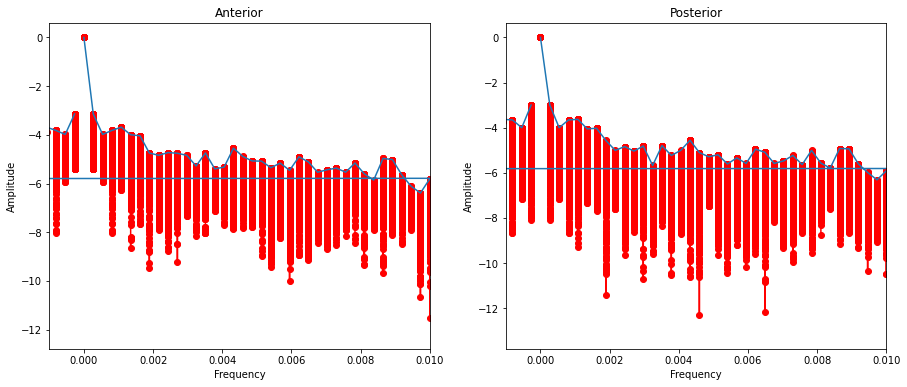

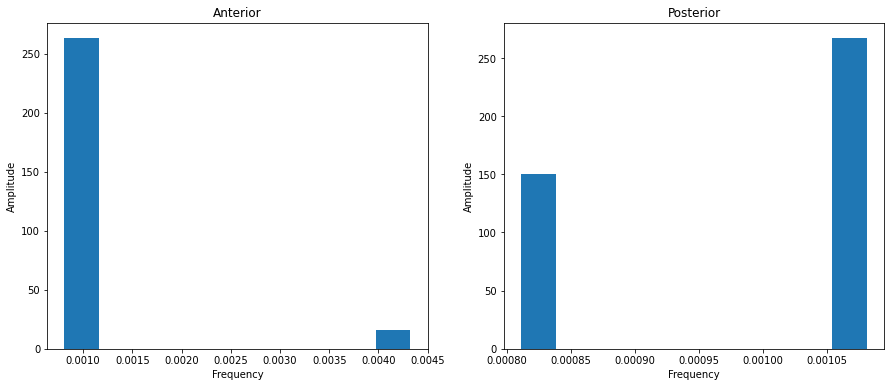

In [6]:
Name = os.path.basename(os.path.splitext(Kymo)[0])
peakA, peakP = AnteriorPosterior(Kymoimage, AnteriorStart, AnteriorEnd, PosteriorStart, PosteriorEnd, Xcalibration,savedir, threshold = Heightthreshold)

peakAT, peakPT = AnteriorPosteriorTime(Kymoimage, AnteriorStart, AnteriorEnd, PosteriorStart, PosteriorEnd, Time_unit,savedir, threshold = Heightthreshold)

AnteriorVelocity = 0
PosteriorVelocity = 0
if peakA > 0:
 AnteriorVelocity = peakAT/peakA
if peakP > 0:
 PosteriorVelocity = peakPT/peakP

print("Estimated Anterior Velocity", AnteriorVelocity, 'um/min')
print("Estimated Posterior Velocity", PosteriorVelocity, 'um/min')

df = pd.DataFrame([[Name,AnteriorVelocity]],columns =['Experiment', 'Velocity'])
df.to_csv(savedir + Name + 'Velocity Anterior' +  '.csv', index = False)  

df = pd.DataFrame([[Name,PosteriorVelocity]],columns =['Experiment', 'Velocity'])
df.to_csv(savedir + Name + 'Velocity Posterior' +  '.csv', index = False)  
